# Plot 1

In [1]:
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
import matplotlib.pyplot as plt

filename = "my_sample_paths.pkl"

# Define a function to simulate a Levy flight trial
def my_levy_trial(v, sv, zr, szr, a, ndt, sndt, alpha, dt, max_steps, return_format='df'):
    
    # Declare variables
    n_steps = 0.0  # Initialize the number of steps
    rt = 0.0  # Initialize the response time
    rhs = dt ** (1.0 / alpha)  # Calculate a scaling factor for the Levy flight step size
    
    my_scale = 1.0/np.sqrt(2)
    
    # Include parameter variabilities (last terms serve to randomize direction of variability)
    zr = zr - 0.5 * szr + szr * stats.uniform.rvs() # draw zr from uniform block between 0 and 1
    ndt = ndt - 0.5 * sndt + sndt * stats.uniform.rvs() # draw t0 from uniform block between 0 and 1
    v = v + sv * stats.norm.rvs() # draw drift rate from Gaussian centered at v
    x = a * zr # scale trial starting point by respective threshold
    
    vdt = v * dt
    
    generated_step = []
    
    # Simulate single DM path
    while x > 0 and x < a and n_steps < max_steps:
        
        noise = rhs * stats.levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=my_scale)
        x = x + vdt + noise
        n_steps += 1.0
        
        generated_step.append(x)

    generated_step = np.array(generated_step)

    rt = n_steps * dt
    
    if x > 0:
        rt = rt + ndt
    else:
        rt = -(rt + ndt)
    
    if (return_format=='df'):
        return pd.DataFrame({'generated_step': generated_step, 'rt': rt}, columns=['generated_step', 'rt'])
    elif (return_format=='steps'):
        return generated_step
    elif (return_format=='rts'):
        return rt

# Simulate paths 
ndt = 0.25
v = 1.5
a = 2
zr = 0.5
sv = 0
szr = 0
sndt = 0
alpha_values = [2, 2, 2, 1, 1, 1]  # example alpha values for your trials

if not os.path.exists(filename):
    datasets = [my_levy_trial(v, sv, zr, szr, a, ndt, sndt, alpha, 0.001, 2000, 'df') for alpha in alpha_values]
    with open(filename, 'wb') as f:
        pickle.dump(datasets, f)
    print("New data was generated")
else:
    with open(filename, 'rb') as f:
        datasets = pickle.load(f)
    print("Data loaded from file")

Data loaded from file


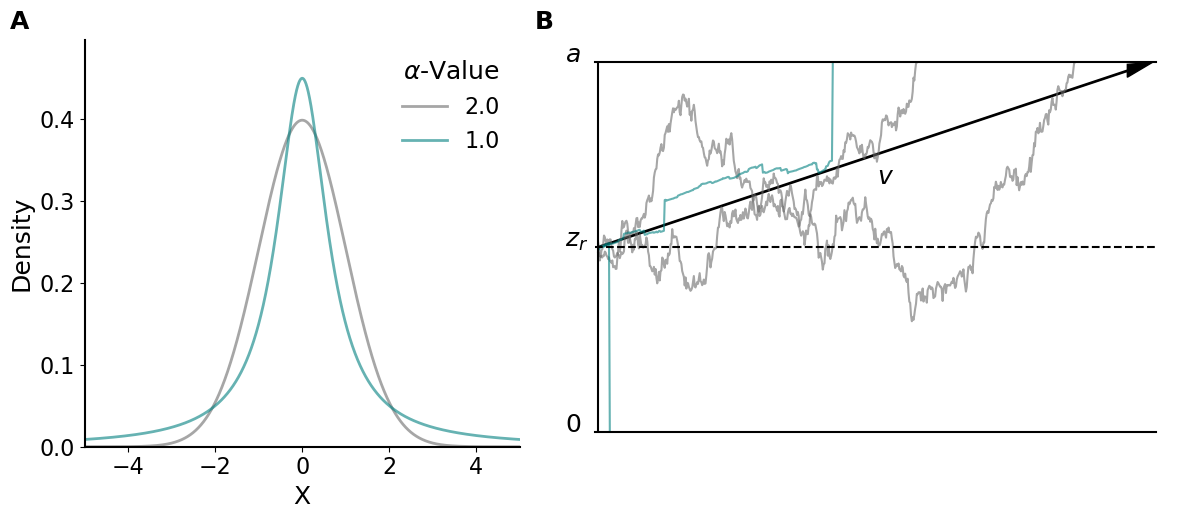

In [2]:
col1 ="#6B6B6B"
col2 ="#d9561a"
col3 = "teal"
my_alpha = 0.6

# PLOT 1
beta = 0
loc = 0
scale = 1/np.sqrt(2)
my_linewidth = 2
my_axis_linewidth = 1.5
my_fontsize = 16

# Generate x values for PDF plots
x_pdf = np.linspace(-5, 5, 2000)

# Compute PDFs for different alpha values
y01 = stats.levy_stable.pdf(x_pdf, alpha=2, beta=beta, loc=loc, scale=scale)  # Normal distribution
y03 = stats.levy_stable.pdf(x_pdf, alpha=1, beta=beta, loc=loc, scale=scale)  # Cauchy distribution

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.4]})

# Plot PDFs on the first subplot
ax1.plot(x_pdf, y01, label='2.0', c=col1, linewidth=my_linewidth, alpha=my_alpha)
ax1.plot(x_pdf, y03, label='1.0', c=col3, linewidth=my_linewidth, alpha=my_alpha)
ax1.set_xlabel(r'X', fontsize=my_fontsize+2)
ax1.set_ylabel('Density', fontsize=my_fontsize+2)
ax1.legend(title=r'$\alpha$-Value', fontsize=my_fontsize, edgecolor='white', title_fontsize=my_fontsize+2)

ax1.set_yticks(np.arange(0, 0.5, 0.1))
ax1.tick_params(axis='both', labelsize=my_fontsize)

# Customize spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(my_axis_linewidth)
ax1.spines['bottom'].set_linewidth(my_axis_linewidth)

# Adjust plot limits and aspect
ax1.set_xlim(x_pdf.min(), x_pdf.max())
ax1.set_ylim(0, ax1.get_ylim()[1] * 1.05)  

# PLOT 2
    
# Plot paths in ax2
colors = [col1, col1, col3, col3]
labels = [r'$\alpha=$2.0', None, None, r'$\alpha=$1.5', None, None]
for dataset, color, label in zip(datasets, colors, labels):
    dataset['generated_step'] = np.clip(dataset['generated_step'], 0, a)
    y = dataset['generated_step']
    x = np.arange(start=0, stop=len(y), step=1)
    ax2.plot(x, y, label=label, c=color, alpha=my_alpha)
    
# Additional plot formatting for ax2
ax2.axhline(y=a, xmin=0.04, xmax=0.96, color='black', linestyle='-', linewidth=my_axis_linewidth)
ax2.axhline(y=a/2, xmin=0.04, xmax=0.96, color='black', linestyle='--', linewidth=my_axis_linewidth)
ax2.axhline(y=0, xmin=0.04, xmax=0.96, color='black', linestyle='-', linewidth=my_axis_linewidth)
ax2.vlines(x=0, ymin=0, ymax=a, color='black', linestyle='-', linewidth=my_axis_linewidth)
ax2.text(-40, a, r'$\it{a}$', fontsize=my_fontsize+2)
ax2.text(-40, a/2, r'${z_r}$', fontsize=my_fontsize+2)
ax2.text(-40, 0, "0", fontsize=my_fontsize+2)

# Hide the grid and axis
ax2.grid(False)
ax2.axis('off')

ax2.arrow(0, a/2, 666, a/2, facecolor='black', edgecolor='black', width=0.0075, 
          length_includes_head=True, head_width=.07, head_length=30)

plt.tight_layout(w_pad=3)

# Move the second subplot down
pos1 = ax1.get_position() 
pos2 = ax2.get_position()  
ax2.set_position([pos2.x0, pos2.y0 - 0.007, pos2.width, pos2.height]) 

ax2.text(335, 1.34, r'$\it{v}$', fontsize=my_fontsize+2)

fig.text(0.0125, 0.99, "A", fontsize=18, ha='left', fontweight='bold')
fig.text(0.45, 0.99, "B", fontsize=18, ha='left', fontweight='bold')

plt.savefig('density_sample_paths.png', dpi=200, 
           bbox_inches='tight', pad_inches=0)
plt.show()